In [ ]:
import os, sys
os.environ["JAX_PLATFORMS"] = "cpu"

from math import factorial
import scipy 
from scipy.special import factorial, comb

from typing import Callable, Tuple
import numpy as np
import matplotlib
import jax
from jax import numpy as jnp
from ml_collections import ConfigDict
jax.config.update("jax_enable_x64", True)  # Enable 64-bit precision

import matplotlib.pyplot as plt
git_root = !git rev-parse --show-toplevel
sys.path.append(git_root[0])

from general_relativity.metrics.minkowski import  minkowski_metric
from general_relativity.metrics.gravitational_waves import  (gravitational_waves_metric_distortion, gravitational_waves_metric)
from differential_geometry.tensor_calculus import DifferentialGeometry 
from differential_geometry.vectorized_tensor_calculus import VectorizedDifferentialGeometry
from einstein_fields.utils.utils_train import (get_model_and_params_checkpoint, load_checkpoint, load_config, make_model, make_callables) 

import absl.logging

# Set ORBAX logging level to FATAL to avoid excessive output
absl.logging.set_verbosity(absl.logging.FATAL)

jnp.set_printoptions(precision=2)

## Gravitational waves

The gravitational wave metric has two canonical representations, either in spherical or cartesian coordinates. Out of these, the cartesian representation is more commonly used.

The GW metric in cartesian is
$$g_{\mu\nu}=\begin{pmatrix}
-1 & 0 & 0 & 0 \\
0 & 1 + h_{+}cos(\omega(t-z)) & h_{\times}cos(\omega(t-z)) & 0 \\
0 & h_{\times}cos(\omega(t-z)) & 1-h_{+}cos(\omega(t-z)) & 0 \\
0 & 0 & 0 & 1 \\
\end{pmatrix}.$$

It represents a wave propagating in the $+z$ direction. For simplicity we will assume $h_{+}=h_{\times}=const$. In a realistic scenario this is a damped wave and the amplitude decreases as it propagates.

### Loading model walkthrough 

In [2]:
# checkpoint directory
run_dir = os.path.abspath("../gravitational_waves/silu_hessian_training")  # for e.g.
# unpack model and params 
model, params_metric = get_model_and_params_checkpoint(run_dir)
# load config file 
config = load_config(run_dir)
# map params into the model and return lambda function over coordinates
model_fn = lambda coords : model.apply(params_metric, coords).reshape(4, 4) 

#### 1. Ring deformations

This is the way gravitational waves affect the spacetime geometry. For visualization purposes it is shown for a ring shape.

In [3]:
## extract + and x polarizations from the EinFields trained GW metric 
h_plus_pred = lambda coords : model_fn(coords)[1, 1] -  minkowski_metric(coords)[1, 1]
h_cross_pred = lambda coords : model_fn(coords)[1, 2] - minkowski_metric(coords)[1, 2]
vmap_h_plus_pred = jax.vmap(h_plus_pred)

### Reconstructing the ring-deformation experiment 

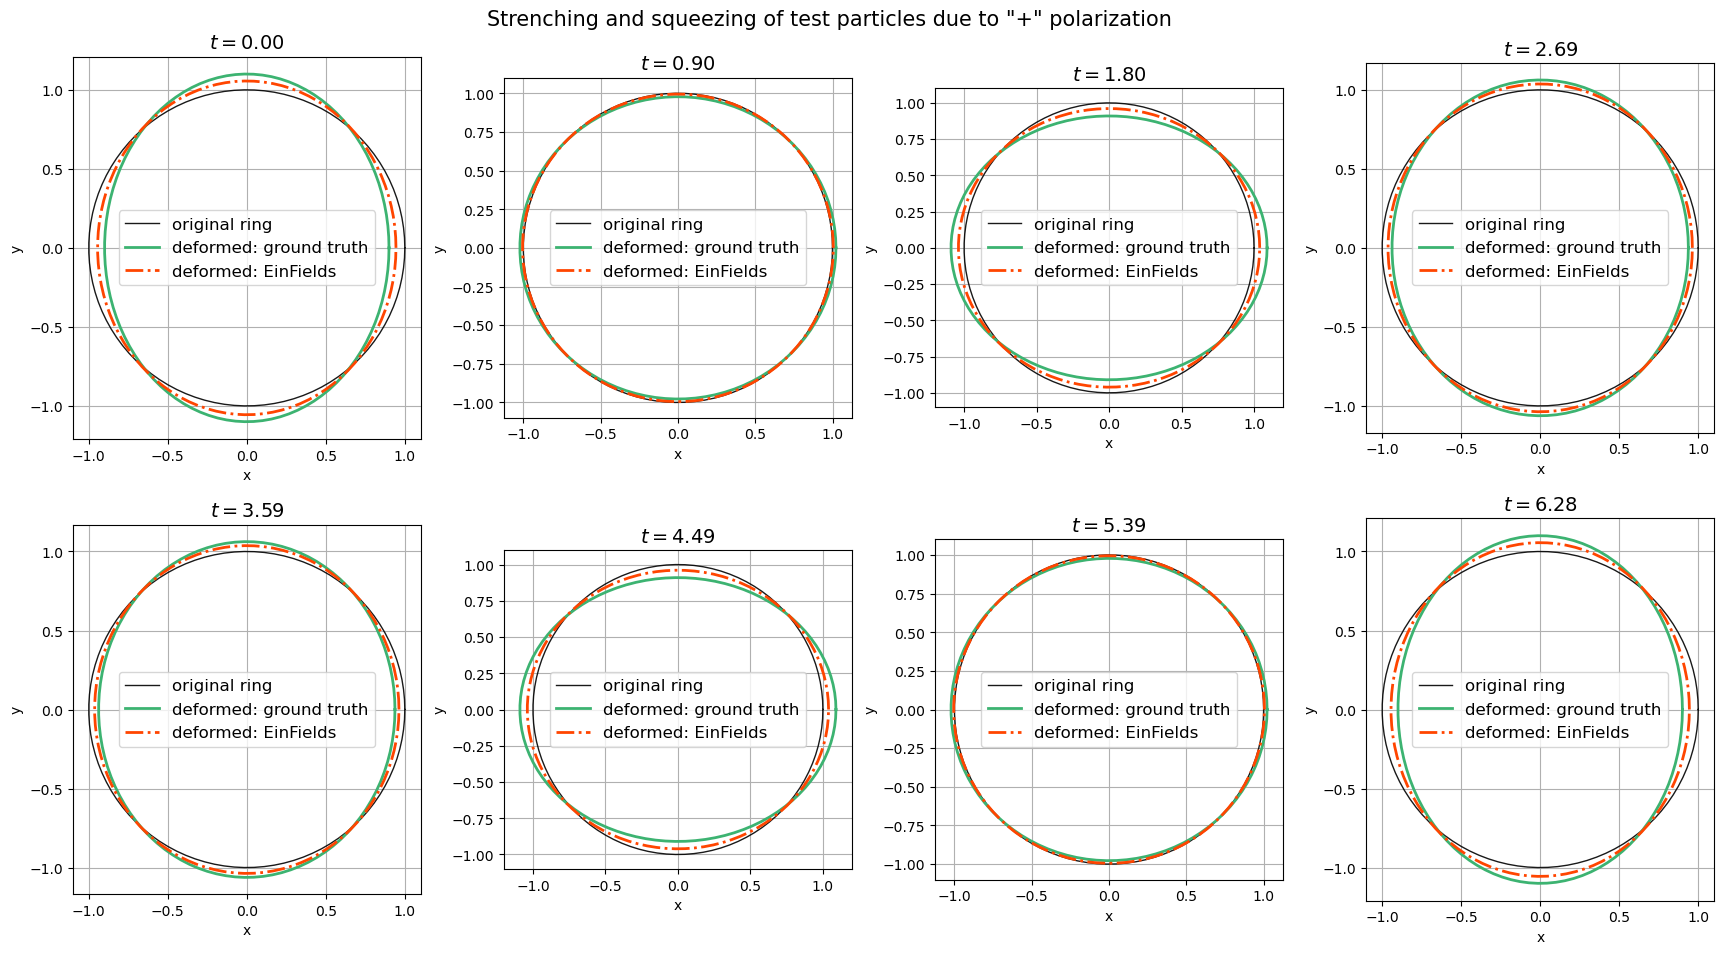

In [4]:
h_plus = 0.2  # amplitude of + polarization
omega = 2.0  
z = jnp.pi/2.0
tlist = jnp.linspace(0.0, 2.0*jnp.pi, 8)

# ring of test particles
num_particles = 100
theta = jnp.linspace(0, 2 * jnp.pi, num_particles)
radius = 1
x0 = radius * jnp.cos(theta)
y0 = radius * jnp.sin(theta)
x_t = x0
y_t = y0

x0_np = np.array(x0)
y0_np = np.array(y0)

fig, axs = plt.subplots(2, 4, figsize=(18, 18))
axs = axs.flatten()
for i, t in enumerate(tlist):
    phase = omega * (t - z)
    # ideally jnp.sin(phase) would suit the initial ring to be same. But, cos will already start at t=0.0 with a deformed ring
    cos_phase = jnp.cos(phase)
    coords = jnp.stack([t * jnp.ones_like(x0), x_t, y_t, jnp.pi / 2 * jnp.ones_like(x0)], axis=-1)
    x_t = (1.0 + 0.5 * 1e5 * vmap_h_plus_pred(coords)) * x0
    y_t = (1.0 - 0.5 * 1e5 * vmap_h_plus_pred(coords)) * y0
    x_t_gt = (1.0 + 0.5 * h_plus * cos_phase) * x0
    y_t_gt = (1.0 - 0.5 * h_plus * cos_phase) * y0
    # print(x_t)
    x_t_np = np.array(x_t)
    y_t_np = np.array(y_t)
    ax = axs[i]
    ax.plot(x0_np, y0_np, c='k', alpha = 0.9, lw=1.0, label=f"original ring")
    ax.plot(x_t_gt, y_t_gt, 'mediumseagreen', linestyle='solid', lw=2.0, label=f"deformed: ground truth")
    ax.plot(x_t_np, y_t_np, 'orangered', linestyle='-.', lw=2.0, label=f"deformed: EinFields")
    
    ax.set_aspect('equal')
    ax.set_title(f'$t = {float(t):.2f}$', fontsize=14)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True)
    ax.legend(fontsize=12)
plt.tight_layout(h_pad=0.001)
plt.subplots_adjust(left=0.08, top=0.60)
plt.suptitle(f'Strenching and squeezing of test particles due to "+" polarization', fontsize=15, y=0.565)

plt.show()

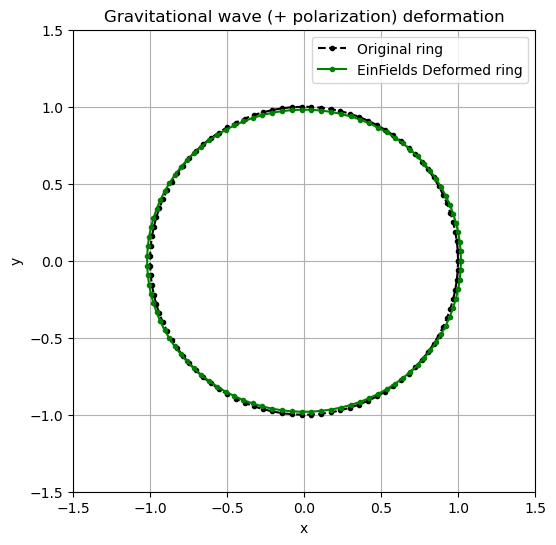

In [5]:
from matplotlib.animation import FuncAnimation

# Gravitational wave parameters
A_plus = 0.1  # Amplitude of + polarization
omega = 2.0  
k = 1.0       
z = 0.0       


# Ring of particles
num_particles = 100
theta = np.linspace(0, 2 * np.pi, num_particles)
radius = 1.0
x0 = radius * np.cos(theta)
y0 = radius * np.sin(theta)

fig, ax = plt.subplots(figsize=(6, 6))
line_original, = ax.plot(x0, y0, 'k--', marker='o',  markersize=3,  label='Original ring')
line_deformed_nn, = ax.plot([], [], 'g-', marker='o',  markersize=3, alpha=1.0, label='EinFields Deformed ring')

ax.set_aspect('equal')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_title('Gravitational wave (+ polarization) deformation')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.grid(True)

def update(frame):
    t = frame / 20.
    coords = jnp.stack([t * jnp.ones_like(x0), x_t, y_t, jnp.zeros_like(x0)], axis=-1)
    x_t_nn = (1.0 + 0.5 * 1e5 * vmap_h_plus_pred(coords)) * x0
    y_t_nn = (1.0 - 0.5 * 1e5 * vmap_h_plus_pred(coords)) * y0
    # line_deformed.set_data(x_t, y_t)
    line_deformed_nn.set_data(x_t_nn, y_t_nn)
    return line_deformed_nn,

ani = FuncAnimation(fig, update, frames=200, interval=33, blit=True, repeat=True)
ani.save("gravitational_waves_ring.gif", writer='pillow', fps=30)

#### 2. Weyl scalar $\Psi_{4}$

Start by defining the metric, lets choose $h_{+}=h_{\times}=10^{-6}$ (realistic amplitudes for LIGO detector are much smaller, but here it is amplified) and $\omega=2$

In the NP (Newman-Penrose) formalism, the Weyl scalar is
$$\Psi_{4}=C_{abcd}n^{a}\bar{m}^{b}n^{c}\bar{m}^{d}.
$$

In this expression, $n$ and $m$ correspond to a real and a complex tetrad (four vectors). The bar denotes complex conjugation. They are part of the 4 null-vectors $\{l^{\mu}, n^{\mu}, m^{\mu}, \bar{m}^{\mu}\}$ with the interpretation that $l^{\mu}$ and $n^{\mu}$ are outgoing and ingoing null-vectors which in spherical coordinates it makes sense to think relative to the radial coordinate, but specifically for gravitational waves is relative to the direction of propagation. These null-vectors can be constructed from the tetrad orthonormal basis. It is important to observe these vectors are not orthogonal or even normalized, but are linearly independent.

With an abuse of notation, $h_{+}$ and $h_{\times}$ will corresspond to the components of the metric, not just the amplitude factor, but the cosine dependence as well. For the GW metric like the one above, this scalar reduces to $\Psi_{4}=-\ddot{h}_{+}+i\ddot{h}_{\times}$. Hence, $\Psi_{4}$ incorporates all that we need to know about the wave.

At first sight, you might think why not extracting the wave dependence from the metric. In Numerical Relativity simulations, certain gauge choices in the coordinate system will alter the components of the metric tensor into something that is much harder to take the wave structure. Furthermore, even though $\Psi_{4}$ is a scalar, its not invariant due to the null-vectors. These null-vectors are formed from the tetrads and don't change as 4-vectors. Also, the tetrads null-vectors are not unique. Despite all these comments, people established techniques to make a gauge-invariant version of $\Psi_{4}$. This is not presented here, but its just to motivate why $\Psi_{4}$ scalar is preferred in Numerical Relativity for gravitational waves extraction.

In [5]:
omega = 2.
amplitude = 1e-6
gw_metric = lambda coords: gravitational_waves_metric(coords, (amplitude, amplitude), omega=omega)
gw_metric_geo = DifferentialGeometry(gw_metric)

gw_metric_nn = lambda coords: model_fn(coords)
gw_metric_geo_nn = DifferentialGeometry(gw_metric_nn)

cartesian_coords = jnp.array([3., 4., 5., 2.]) # (t, x, y, z)

l = 1 / jnp.sqrt(2) * jnp.array([1., 1., 0., 0.])
n = 1 / jnp.sqrt(2) * jnp.array([1., 0., 0., -1.])
m = 1 / jnp.sqrt(2) * jnp.array([0., 1., 1j, 0.])

h_plus_ddot = -amplitude * omega**2 * jnp.cos(omega * (cartesian_coords[0] - cartesian_coords[3]))

weyl_scalar = jnp.einsum('ijkl, i, j, k, l ->', gw_metric_geo.weyl_curvature_tensor(cartesian_coords), n, m.conj(), n, m.conj())
weyl_scalar_nn = jnp.einsum('ijkl, i, j, k, l ->', gw_metric_geo_nn.weyl_curvature_tensor(cartesian_coords), n, m.conj(), n, m.conj())

# jnp.set_printoptions(precision=2, formatter={'complex_kind': '{:0.2e}'.format})
print(f"Cartesian coordinates: {cartesian_coords}")
print(" ")
print(f"AD queried Weyl scalar from ground truth metric : {jnp.array([weyl_scalar])}")
print(" ")
print(f"AD queried Weyl scalar from EinFields parmetrization :  {jnp.array([weyl_scalar_nn])}")
print(" ")
print(f"Analytical Weyl scalar: {jnp.array([-h_plus_ddot + 1j * h_plus_ddot])}")

Cartesian coordinates: [3. 4. 5. 2.]
 
AD queried Weyl scalar from ground truth metric : [-1.66e-06+1.66e-06j]
 
AD queried Weyl scalar from EinFields parmetrization :  [-1.66e-06+1.66e-06j]
 
Analytical Weyl scalar: [-1.66e-06+1.66e-06j]


#### Spin-Weighted Spherical Harmonics (SWSH) expansion of the gravitational waves metric 

In numerical relativity and gravitational wave (GW) analysis, it is common to expand the metric perturbations or the Newman-Penrose scalar $\psi_4$ in terms of \emph{spin-weighted spherical harmonics} (SWSHs). This expansion has several motivations:

1. The GW strain $h = h_+ - i h_\times$ is a \emph{spin-weight $-2$ field} on the sphere.
2. By expanding $h$ in SWSHs, we can decompose the angular dependence into orthogonal modes, leaving only the time and radial dependence in each mode:
$
\begin{equation}
h(t, r, \theta, \phi) = \sum_{l=2}^\infty \sum_{m=-\ell}^{\ell} h^{(\ell, m)}(t, r) \; {}_{-2}Y_{lm}(\theta, \phi),
\end{equation}
$
where ${}_{-2}Y_{lm}$ are the spin-weight $-2$ spherical harmonics and reads: 
Where, the SWSH basis is given by goldberg et.al 

$
\begin{equation}
   {}_{s}Y_{\ell m}(\theta, \phi) = (-1)^{l+m-s} \left[
\frac{2\ell + 1}{4\pi}
\frac{(\ell + m)! (\ell - m)!}{(\ell + s)! (\ell - s)!}
\right]^{1/2}
\sin^{2\ell} \left( \frac{\theta}{2} \right) e^{im \phi} \\ \nonumber
\sum_{r=0}^{\ell - s} (-1)^{r}
\binom{\ell - s}{r}
\binom{\ell + s}{r + s - m}
\cot^{2r + s - m} \left( \frac{\theta}{2} \right).
\end{equation}
$

3. This decomposition \emph{removes the angular dependence} from the evolution equations, enabling a mode-by-mode analysis of gravitational radiation.
4. It also allows clean extraction of waveform data at finite radius or at null infinity, as each $(l, m)$ mode can be tracked separately.
5. In perturbative frameworks, the metric perturbation $h_{\mu \nu}$ itself can also be expanded in tensor spherical harmonics or recast in terms of SWSHs when focusing on radiative degrees of freedom.

$
\begin{equation}
    h^{(\ell, m)}(t, r) = \int_{\mathbb{S}^2} h(t, r, \theta, \phi) {}_{-2}\overline{Y}_{lm}(\theta, \phi) d\Omega 
\end{equation}
$
Thus, the SWSH expansion isolates the angular structure and leaves us with a clean, one-dimensional time evolution for each mode, greatly simplifying the extraction and interpretation of gravitational wave signals from simulations.

One then typically solve Equation (2) via numerical integration. We opt for the trapezoidal method inorder to perform the integral over the angular element.


In [6]:
def spin_weighted_spherical_harmonics_basis(s: float, l: float, m: float) -> float:
    """
    Computes the spin-weighted spherical harmonics basis function.

    Spin-weighted spherical harmonics generalize the standard spherical harmonics
    to functions carrying spin weight `s` on the sphere, and are widely used in
    gravitational wave physics, CMB analysis, and spin field decompositions on
    spherical manifolds.

    Given spin weight `s`, angular momentum number `l`, and azimuthal number `m`,
    this function returns the corresponding spin-weighted spherical harmonics
    basis function evaluated symbolically or numerically, depending on the backend.

    Args:
        s: Spin weight (can be fractional but typically integer or half-integer).
        l: Angular momentum quantum number (l >= 0).
        m: Azimuthal quantum number (-l <= m <= l).

    Returns:
        A callable or symbolic representation of the spin-weighted spherical
        harmonics basis function ${}_s Y_{l m}(θ, φ)$.

    Notes:
        - The spin-weighted spherical harmonics satisfy orthogonality and
          completeness on the sphere with the appropriate spin-weight measure.
        - For `s = 0`, the function reduces to the standard spherical harmonics
          $Y_{l m}(θ, φ)$.
        - This implementation assumes the Condon-Shortley phase convention.

    References:
        - Newman, E., & Penrose, R. (1966). Note on the Bondi-Metzner-Sachs
          group. Journal of Mathematical Physics, 7(5), 863-870.
        - Goldberg, J. N., et al. (1967). Spin-s spherical harmonics and
          $\eth$. Journal of Mathematical Physics, 8(11), 2155-2161.
        - Geller, D., & Mayeli, A. (2009). Continuous wavelets on the sphere.
          Mathematical Journal.

    Example:
        >>> Y = spin_weighted_spherical_harmonics_basis(s=-2, l=2, m=0)
        >>> theta = jnp.linspace(0, jnp.pi, 100)
        >>> phi = jnp.linspace(0, 2 * jnp.pi, 100)
        >>> values = Y(theta, phi)

    """
    prefactor = (-1.0) ** (l + m - s)
    prefactor *= np.sqrt(
        factorial(l + m) *
        factorial(l - m) *
        (2 * l + 1) /
        (4 * np.pi * factorial(l + s) * factorial(l - s))
    )

    def Y(angular_coords: np.ndarray):
        """
        Evaluates the spin-weighted spherical harmonics at given angles.

        Args:
            angular_coords (np.ndarray): Array-like with [theta, phi] in radians.

        Returns:
            complex: Value of ${}_s Y_{l m}(θ, φ)$ at the given point.
        """
        theta, phi = angular_coords

        r_min = int(max(m - s, 0))
        r_max = int(min(l - s, l + m))

        alternating_sum = 0.0
        for r in range(r_min, r_max + 1):
            term = (
                (-1) ** r *
                comb(l - s, r, exact=True) *
                comb(l + s, r + s - m, exact=True) *
                np.sin(theta / 2) ** (2 * l - 2 * r - s + m) *
                np.cos(theta / 2) ** (2 * r + s - m)
            )
            alternating_sum += term

        return prefactor * np.exp(1j * m * phi) * alternating_sum

    return Y


<>:2: SyntaxWarning: invalid escape sequence '\e'
<>:2: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_4007165/2555702044.py:2: SyntaxWarning: invalid escape sequence '\e'
  """


### Visualization of SWSHs for different l, m, s. 

##### For elaborate visualizations of different modes refer to library: https://spheroidal.readthedocs.io/en/latest/ 

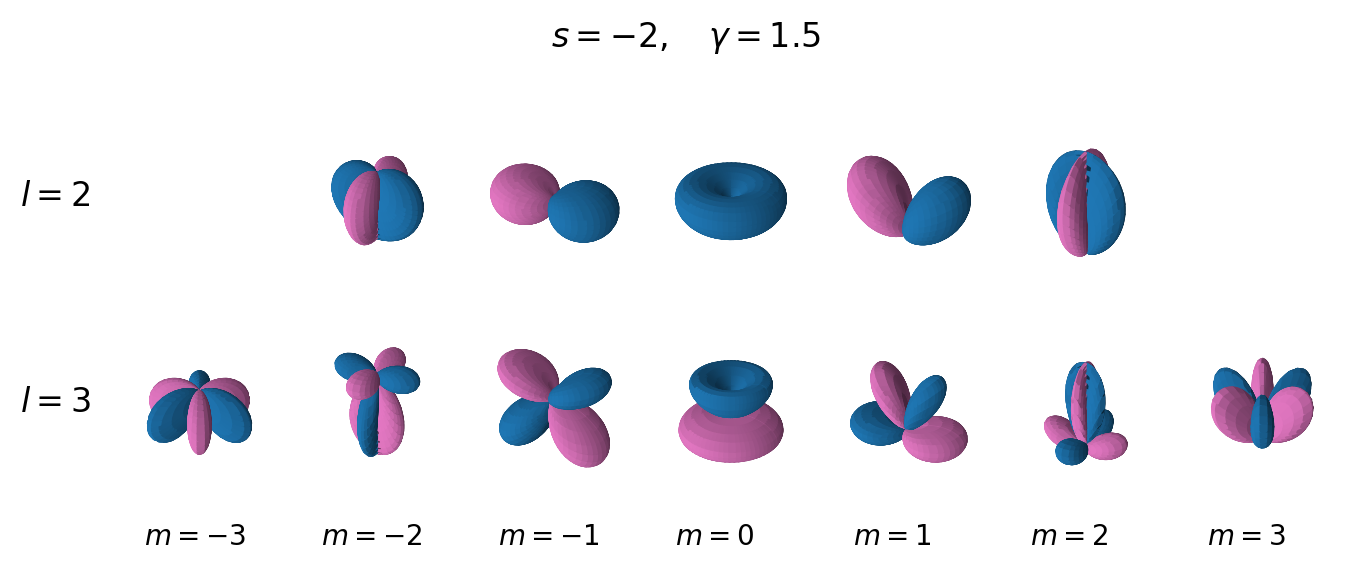

### Constructing the complex gravitational wave strain 

In [7]:
def gw_strain(h_plus, h_cross) -> float: 
    """returns the GWs complex strain""" 
    @jax.jit
    def h_complex(spherical_coord: jax.Array) -> jax.Array: 
        """returns the complex strain value"""
        return h_plus(spherical_coord) + 1.0j*h_cross(spherical_coord)
    return h_complex

In [8]:
s = -2
l, m = 2, 2
theta = jnp.linspace(0+1.e-2, jnp.pi-1.e-2, 50)
phi = jnp.linspace(0, 2*np.pi, 50, endpoint=False)
Theta, Phi = jnp.meshgrid(theta, phi, indexing='ij')
angular_grid = jnp.stack((Theta, Phi), axis=-1).reshape(-1, 2)

spherical_range = [[0.0, 10], [1.0, 1.0], [0.0+1.e-2, jnp.pi-1.e-2], [0.0, 2.0*jnp.pi]]
grid_shape = [50, 1, 50, 50]
axes = [jnp.linspace(start, stop, steps, endpoint=endpoint) for (start, stop), steps, endpoint in zip(spherical_range, grid_shape, [True, True, True, False])]
X = jnp.meshgrid(*axes, indexing='ij')
spherical_grid = jnp.stack(X, axis=-1).reshape(-1, 4)
del X

dtheta = theta[1] - theta[0]
dphi = phi[1] - phi[0]
dOmega = np.sin(Theta) * dtheta * dphi

s,l,m=-2, 2, 2

def compute_swsh_arrays(
    s: int,
    l: int,
    m: int,
    angular_grid: np.ndarray,
    swsh_basis_fn: Callable
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Computes conjugate SWSH arrays for +m and -m modes.
    """
    swsh_p = np.array([
        np.conj(swsh_basis_fn(s, l, m)(grid))
        for grid in angular_grid
    ])
    swsh_m = np.array([
        np.conj(swsh_basis_fn(s, l, -m)(grid))
        for grid in angular_grid
    ])
    return swsh_p, swsh_m

swsh_p, swsh_m = compute_swsh_arrays(
    s=-2,
    l=2,
    m=2,
    angular_grid=angular_grid,
    swsh_basis_fn=spin_weighted_spherical_harmonics_basis
)


h_plus =  lambda coords: gravitational_waves_metric_distortion(coords, (1e-6, 1e-6), 1.)[1, 1]
h_cross = lambda coords: gravitational_waves_metric_distortion(coords, (1e-6, 1e-6), 1.)[1, 2]

h_plus_pred =  lambda coords: model_fn(coords)[1, 1] - minkowski_metric(coords)[1, 1]
h_cross_pred = lambda coords: model_fn(coords)[1, 2] - minkowski_metric(coords)[1, 2]

h_gt  = jax.vmap(gw_strain(h_plus, h_cross))(spherical_grid)
h_nn = jax.vmap(gw_strain(h_plus_pred, h_cross_pred))(spherical_grid) 

h22_rollout = []
h22_pred_rollout = [] 

h22_rollout_m = []
h22_pred_rollout_m = [] 

for t_idx in range(100):
    h_at_tp = h_gt.reshape(50, 1, 50, 50)[t_idx, 0, :, :]  # shape (N_theta, N_phi)
    hp_at_tp = h_nn.reshape(50, 1, 50, 50)[t_idx, 0, :, :]  # shape (N_theta, N_phi)

    integrand = h_at_tp * swsh_p.reshape(50, 50) * jnp.sin(Theta)
    integrand_pred = hp_at_tp * swsh_p.reshape(50, 50) * jnp.sin(Theta)

    integrand_m = h_at_tp * swsh_m.reshape(50, 50) * jnp.sin(Theta)
    integrand_pred_m = hp_at_tp * swsh_m.reshape(50, 50) * jnp.sin(Theta)

    h22_rollout.append(jnp.linalg.norm(np.trapz(np.trapz(integrand, phi, axis=1), theta, axis=0)))
    h22_pred_rollout.append(jnp.linalg.norm(np.trapz(np.trapz(integrand_pred, phi, axis=1), theta, axis=0)))

    h22_rollout_m.append(jnp.linalg.norm(np.trapz(np.trapz(integrand_m, phi, axis=1), theta, axis=0)))
    h22_pred_rollout_m.append(jnp.linalg.norm(np.trapz(np.trapz(integrand_pred_m, phi, axis=1), theta, axis=0)))

h22_rollout, h22_pred_rollout = jnp.array(h22_rollout), jnp.array(h22_pred_rollout)
h22_rollout_m, h22_pred_rollout_m = jnp.array(h22_rollout_m), jnp.array(h22_pred_rollout_m)

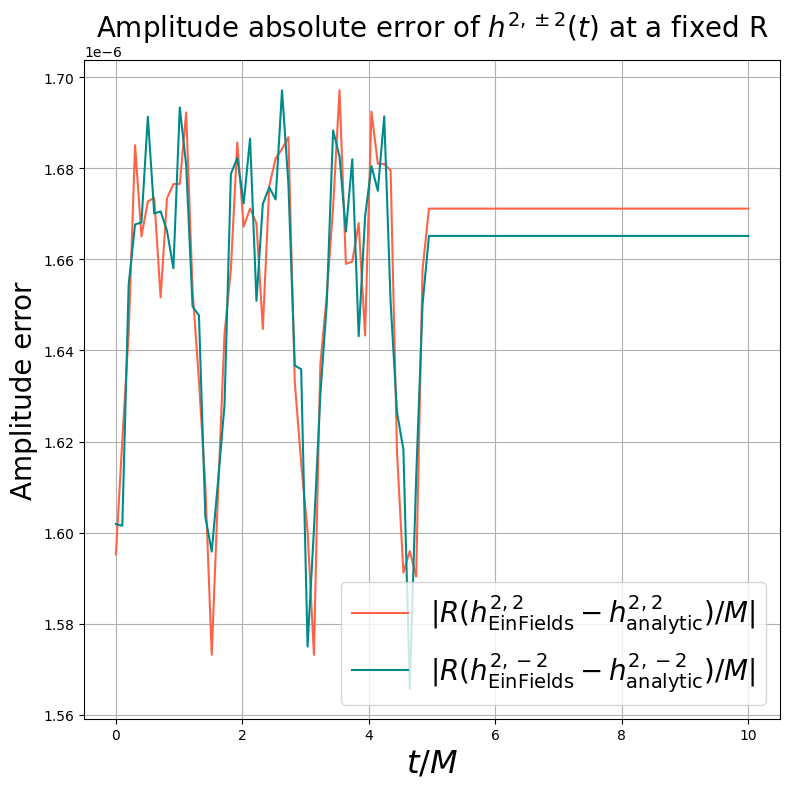

In [9]:
diff = jnp.abs(h22_rollout - h22_pred_rollout)
diff_m = jnp.abs(h22_rollout_m - h22_pred_rollout_m)

plt.figure(figsize=(8,8))
plt.plot(jnp.linspace(0.0, 10., 100), diff, color='tomato', label=r'$|R (h^{2,2}_{\mathrm{EinFields}} - h^{2,2}_{\mathrm{analytic}})/M|$')
plt.plot(jnp.linspace(0.0, 10., 100), diff_m, color='darkcyan', label=r'$|R (h^{2,-2}_{\mathrm{EinFields}} - h^{2,-2}_{\mathrm{analytic}})/M|$')
plt.xlabel(r'$t/M$', fontsize=23)
plt.ylabel(r'Amplitude error', fontsize=20)
plt.title(r'Amplitude absolute error of $h^{2,\pm 2}(t)$ at a fixed R', fontsize=20)
plt.grid()
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()